In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.colors import ListedColormap
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm
import random

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Define class names
class_names = [
    "Unlabeled", "Building", "Fence", "Other", "Pedestrian", "Pole",
    "Roadline", "Road", "Sidewalk", "Vegetation", "Car", "Wall", "Traffic sign"
]
num_classes = len(class_names)

# Define paths for Kaggle
dataset_path = "/kaggle/input/q2-unet/dataset_256"
train_images_path = os.path.join(dataset_path, "train", "images")
train_labels_path = os.path.join(dataset_path, "train", "labels")
test_images_path = os.path.join(dataset_path, "test", "images")
test_labels_path = os.path.join(dataset_path, "test", "labels")

# Define U-Net components
class DoubleConv(nn.Module):
    """(Conv => BN => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv without skip connections"""
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        # Use transposed convolution for upsampling
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(out_channels, out_channels)

    def forward(self, x):
        # No concatenation with skip connections
        x = self.up(x)
        return self.conv(x)

class UNetNoSkip(nn.Module):
    """Modified U-Net without skip connections"""
    def __init__(self, n_channels, n_classes):
        super(UNetNoSkip, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        # Encoder path (contracting)
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        
        # Bottleneck
        self.down4 = Down(512, 1024)
        
        # Decoder path (expansive) without skip connections
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        
        # Final convolution
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder path
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        
        # Bottleneck
        x5 = self.down4(x4)
        
        # Decoder path without skip connections
        x = self.up1(x5)
        x = self.up2(x)
        x = self.up3(x)
        x = self.up4(x)
        
        # Final layer
        logits = self.outc(x)
        return logits

# Dataset class
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.images = sorted(os.listdir(images_dir))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.images_dir, img_name)
        mask_path = os.path.join(self.masks_dir, img_name)
        
        # Load image and mask
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path))
        
        # Extract class IDs from mask
        if len(mask.shape) > 2:
            mask = mask[:, :, 0]  # Take first channel if multiple channels
        
        # Convert to tensors and normalize image
        if self.transform:
            # Apply transformations if provided
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        else:
            # Basic transformation
            image = image.transpose(2, 0, 1).astype(np.float32) / 255.0
            image = torch.from_numpy(image)
            mask = torch.from_numpy(mask).long()  # Ensure mask is Long type
        
        return image, mask

# Calculate Mean IoU
def calculate_miou(pred, target, num_classes):
    iou_list = []
    pred = pred.argmax(dim=1).view(-1)
    target = target.view(-1)
    
    # Calculate IoU for each class
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        
        if union == 0:
            iou = 1.0  # If there's no ground truth and no prediction, consider it perfect
        else:
            iou = intersection / union
        
        iou_list.append(iou)
    
    return np.mean(iou_list)

# Function to visualize predictions
def visualize_prediction(image, mask, pred, idx, prefix="no_skip"):
    """
    Visualize the image, ground truth mask and prediction side by side
    """
    # Create a colormap for the segmentation masks
    colors = plt.cm.tab20(np.linspace(0, 1, num_classes))
    custom_cmap = ListedColormap(colors)
    
    # Convert tensors to numpy arrays
    if torch.is_tensor(image):
        image = image.cpu().numpy().transpose(1, 2, 0)  # Convert from CxHxW to HxWxC
        
    if torch.is_tensor(mask):
        mask = mask.cpu().numpy()
        
    if torch.is_tensor(pred):
        pred = pred.argmax(dim=0).cpu().numpy()
    
    # Denormalize image if it was normalized using ImageNet mean/std
    if image.min() < 0 or image.max() <= 1.0:
        # Check if image is normalized with ImageNet stats
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        
        # Denormalize
        image = image * std + mean
        image = np.clip(image, 0, 1)
        image = (image * 255).astype(np.uint8)
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot original image
    axes[0].imshow(image)
    axes[0].set_title("Input Image")
    axes[0].axis('off')
    
    # Plot ground truth mask
    axes[1].imshow(custom_cmap(mask))
    axes[1].set_title("Ground Truth")
    axes[1].axis('off')
    
    # Plot prediction
    axes[2].imshow(custom_cmap(pred))
    axes[2].set_title("Prediction (No Skip)")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig(f"{prefix}_prediction_{idx}.png")
    plt.close()

# Train function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, device='cuda'):
    model.to(device)
    best_miou = 0.0
    
    # Track metrics
    train_losses = []
    val_losses = []
    train_mious = []
    val_mious = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_miou = 0.0
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        progress_bar = tqdm(train_loader, desc="Training")
        
        for images, masks in progress_bar:
            images = images.to(device)
            masks = masks.to(device)
            
            # Ensure masks are in long format for CrossEntropyLoss
            masks = masks.long()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Calculate metrics
            train_loss += loss.item() * images.size(0)
            train_miou += calculate_miou(outputs, masks, num_classes) * images.size(0)
            
            # Update progress bar
            progress_bar.set_postfix(loss=loss.item())
        
        train_loss = train_loss / len(train_loader.dataset)
        train_miou = train_miou / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_mious.append(train_miou)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_miou = 0.0
        
        with torch.no_grad():
            progress_bar = tqdm(val_loader, desc="Validation")
            
            for images, masks in progress_bar:
                images = images.to(device)
                masks = masks.to(device)
                
                # Ensure masks are in long format for CrossEntropyLoss
                masks = masks.long()
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                val_loss += loss.item() * images.size(0)
                val_miou += calculate_miou(outputs, masks, num_classes) * images.size(0)
        
        val_loss = val_loss / len(val_loader.dataset)
        val_miou = val_miou / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_mious.append(val_miou)
        
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train mIoU: {train_miou:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val mIoU: {val_miou:.4f}")
        
        # Save model if validation mIoU improved
        if val_miou > best_miou:
            best_miou = val_miou
            torch.save(model.state_dict(), 'best_unet_noskip_model.pth')
            print(f"Model saved with validation mIoU: {val_miou:.4f}")
    
    # Plot training curves
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves (No Skip Connections)')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_mious, label='Train mIoU')
    plt.plot(val_mious, label='Val mIoU')
    plt.xlabel('Epochs')
    plt.ylabel('mIoU')
    plt.legend()
    plt.title('mIoU Curves (No Skip Connections)')
    
    plt.tight_layout()
    plt.savefig('training_curves_noskip.png')
    plt.show()
    
    return train_losses, val_losses, train_mious, val_mious

# Test model and visualize predictions
def test_model(model, test_loader, device='cuda'):
    model.to(device)
    model.eval()
    
    test_miou = 0.0
    samples_to_visualize = 5
    visualized = 0
    
    with torch.no_grad():
        for idx, (images, masks) in enumerate(tqdm(test_loader, desc="Testing")):
            images = images.to(device)
            masks = masks.to(device)
            
            # Ensure masks are in long format for CrossEntropyLoss
            masks = masks.long()
            
            outputs = model(images)
            
            # Calculate mIoU
            batch_miou = calculate_miou(outputs, masks, num_classes)
            test_miou += batch_miou * images.size(0)
            
            # Visualize a few predictions
            if visualized < samples_to_visualize:
                for i in range(min(images.size(0), samples_to_visualize - visualized)):
                    visualize_prediction(
                        images[i].cpu(), 
                        masks[i].cpu(), 
                        outputs[i].cpu(), 
                        visualized,
                        prefix="no_skip"
                    )
                    visualized += 1
                    if visualized >= samples_to_visualize:
                        break
    
    test_miou = test_miou / len(test_loader.dataset)
    print(f"Test mIoU: {test_miou:.4f}")
    
    return test_miou



Using device: cuda


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Using albumentations library for transformations
Training dataset size: 1600
Validation dataset size: 400
Test dataset size: 500
Number of trainable parameters: 27910861
Starting model training for U-Net without skip connections...
Epoch 1/50


Validation: 100%|██████████| 50/50 [00:05<00:00,  9.82it/s]


Epoch 1/50, Train Loss: 0.9372, Train mIoU: 0.2715, Val Loss: 0.7692, Val mIoU: 0.2901
Model saved with validation mIoU: 0.2901
Epoch 2/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.11it/s]


Epoch 2/50, Train Loss: 0.4789, Train mIoU: 0.3656, Val Loss: 0.5237, Val mIoU: 0.3641
Model saved with validation mIoU: 0.3641
Epoch 3/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.13it/s]


Epoch 3/50, Train Loss: 0.4011, Train mIoU: 0.3831, Val Loss: 0.5033, Val mIoU: 0.3654
Model saved with validation mIoU: 0.3654
Epoch 4/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.08it/s]


Epoch 4/50, Train Loss: 0.3672, Train mIoU: 0.3941, Val Loss: 0.3815, Val mIoU: 0.3989
Model saved with validation mIoU: 0.3989
Epoch 5/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.05it/s]


Epoch 5/50, Train Loss: 0.3155, Train mIoU: 0.4201, Val Loss: 0.3447, Val mIoU: 0.4124
Model saved with validation mIoU: 0.4124
Epoch 6/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.11it/s]


Epoch 6/50, Train Loss: 0.2899, Train mIoU: 0.4320, Val Loss: 0.2821, Val mIoU: 0.4526
Model saved with validation mIoU: 0.4526
Epoch 7/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.20it/s]


Epoch 7/50, Train Loss: 0.2784, Train mIoU: 0.4476, Val Loss: 0.2967, Val mIoU: 0.4363
Epoch 8/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.18it/s]


Epoch 8/50, Train Loss: 0.2677, Train mIoU: 0.4537, Val Loss: 0.2494, Val mIoU: 0.4837
Model saved with validation mIoU: 0.4837
Epoch 9/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.22it/s]


Epoch 9/50, Train Loss: 0.2397, Train mIoU: 0.4865, Val Loss: 0.3084, Val mIoU: 0.4842
Model saved with validation mIoU: 0.4842
Epoch 10/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.09it/s]


Epoch 10/50, Train Loss: 0.2267, Train mIoU: 0.5151, Val Loss: 0.2533, Val mIoU: 0.5155
Model saved with validation mIoU: 0.5155
Epoch 11/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.19it/s]


Epoch 11/50, Train Loss: 0.2266, Train mIoU: 0.5220, Val Loss: 0.4326, Val mIoU: 0.4262
Epoch 12/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.14it/s]


Epoch 12/50, Train Loss: 0.2163, Train mIoU: 0.5344, Val Loss: 0.2145, Val mIoU: 0.5550
Model saved with validation mIoU: 0.5550
Epoch 13/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.18it/s]


Epoch 13/50, Train Loss: 0.1853, Train mIoU: 0.5681, Val Loss: 0.2043, Val mIoU: 0.5584
Model saved with validation mIoU: 0.5584
Epoch 14/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.15it/s]


Epoch 14/50, Train Loss: 0.1757, Train mIoU: 0.5832, Val Loss: 0.1853, Val mIoU: 0.5880
Model saved with validation mIoU: 0.5880
Epoch 15/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 12.97it/s]


Epoch 15/50, Train Loss: 0.1677, Train mIoU: 0.5917, Val Loss: 0.1803, Val mIoU: 0.5847
Epoch 16/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.17it/s]


Epoch 16/50, Train Loss: 0.1631, Train mIoU: 0.6005, Val Loss: 0.1877, Val mIoU: 0.5866
Epoch 17/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.16it/s]


Epoch 17/50, Train Loss: 0.1566, Train mIoU: 0.6084, Val Loss: 0.1747, Val mIoU: 0.5905
Model saved with validation mIoU: 0.5905
Epoch 18/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.19it/s]


Epoch 18/50, Train Loss: 0.1501, Train mIoU: 0.6163, Val Loss: 0.1619, Val mIoU: 0.6140
Model saved with validation mIoU: 0.6140
Epoch 19/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.17it/s]


Epoch 19/50, Train Loss: 0.1465, Train mIoU: 0.6286, Val Loss: 0.1681, Val mIoU: 0.6121
Epoch 20/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.11it/s]


Epoch 20/50, Train Loss: 0.1421, Train mIoU: 0.6386, Val Loss: 0.1620, Val mIoU: 0.6164
Model saved with validation mIoU: 0.6164
Epoch 21/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.22it/s]


Epoch 21/50, Train Loss: 0.1377, Train mIoU: 0.6508, Val Loss: 0.1777, Val mIoU: 0.6073
Epoch 22/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.18it/s]


Epoch 22/50, Train Loss: 0.1339, Train mIoU: 0.6604, Val Loss: 0.1493, Val mIoU: 0.6446
Model saved with validation mIoU: 0.6446
Epoch 23/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.15it/s]


Epoch 23/50, Train Loss: 0.1307, Train mIoU: 0.6649, Val Loss: 0.1487, Val mIoU: 0.6416
Epoch 24/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.10it/s]


Epoch 24/50, Train Loss: 0.1290, Train mIoU: 0.6725, Val Loss: 0.1723, Val mIoU: 0.6195
Epoch 25/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.10it/s]


Epoch 25/50, Train Loss: 0.1274, Train mIoU: 0.6769, Val Loss: 0.1564, Val mIoU: 0.6493
Model saved with validation mIoU: 0.6493
Epoch 26/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.16it/s]


Epoch 26/50, Train Loss: 0.1224, Train mIoU: 0.6823, Val Loss: 0.1433, Val mIoU: 0.6622
Model saved with validation mIoU: 0.6622
Epoch 27/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.21it/s]


Epoch 27/50, Train Loss: 0.1192, Train mIoU: 0.6893, Val Loss: 0.1505, Val mIoU: 0.6564
Epoch 28/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.21it/s]


Epoch 28/50, Train Loss: 0.1171, Train mIoU: 0.6969, Val Loss: 0.1457, Val mIoU: 0.6618
Epoch 29/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.09it/s]


Epoch 29/50, Train Loss: 0.1170, Train mIoU: 0.6967, Val Loss: 0.1506, Val mIoU: 0.6636
Model saved with validation mIoU: 0.6636
Epoch 30/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.03it/s]


Epoch 30/50, Train Loss: 0.1146, Train mIoU: 0.7046, Val Loss: 0.1393, Val mIoU: 0.6721
Model saved with validation mIoU: 0.6721
Epoch 31/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.11it/s]


Epoch 31/50, Train Loss: 0.1119, Train mIoU: 0.7060, Val Loss: 0.1432, Val mIoU: 0.6692
Epoch 32/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.13it/s]


Epoch 32/50, Train Loss: 0.1125, Train mIoU: 0.7062, Val Loss: 0.1336, Val mIoU: 0.6737
Model saved with validation mIoU: 0.6737
Epoch 33/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.17it/s]


Epoch 33/50, Train Loss: 0.1079, Train mIoU: 0.7141, Val Loss: 0.1379, Val mIoU: 0.6688
Epoch 34/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.17it/s]


Epoch 34/50, Train Loss: 0.1077, Train mIoU: 0.7130, Val Loss: 0.1342, Val mIoU: 0.6833
Model saved with validation mIoU: 0.6833
Epoch 35/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.10it/s]


Epoch 35/50, Train Loss: 0.1060, Train mIoU: 0.7198, Val Loss: 0.1301, Val mIoU: 0.6847
Model saved with validation mIoU: 0.6847
Epoch 36/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.19it/s]


Epoch 36/50, Train Loss: 0.1050, Train mIoU: 0.7208, Val Loss: 0.1448, Val mIoU: 0.6634
Epoch 37/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.18it/s]


Epoch 37/50, Train Loss: 0.1026, Train mIoU: 0.7295, Val Loss: 0.1293, Val mIoU: 0.6867
Model saved with validation mIoU: 0.6867
Epoch 38/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.11it/s]


Epoch 38/50, Train Loss: 0.1016, Train mIoU: 0.7321, Val Loss: 0.1401, Val mIoU: 0.6850
Epoch 39/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.20it/s]


Epoch 39/50, Train Loss: 0.1177, Train mIoU: 0.7169, Val Loss: 2.9733, Val mIoU: 0.2964
Epoch 40/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.00it/s]


Epoch 40/50, Train Loss: 0.1968, Train mIoU: 0.5789, Val Loss: 0.1536, Val mIoU: 0.6619
Epoch 41/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.12it/s]


Epoch 41/50, Train Loss: 0.1120, Train mIoU: 0.7119, Val Loss: 0.1306, Val mIoU: 0.6811
Epoch 42/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.09it/s]


Epoch 42/50, Train Loss: 0.1013, Train mIoU: 0.7309, Val Loss: 0.1292, Val mIoU: 0.6865
Epoch 43/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.15it/s]


Epoch 43/50, Train Loss: 0.0974, Train mIoU: 0.7385, Val Loss: 0.1243, Val mIoU: 0.6986
Model saved with validation mIoU: 0.6986
Epoch 44/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.14it/s]


Epoch 44/50, Train Loss: 0.0954, Train mIoU: 0.7433, Val Loss: 0.1273, Val mIoU: 0.6917
Epoch 45/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.11it/s]


Epoch 45/50, Train Loss: 0.0947, Train mIoU: 0.7463, Val Loss: 0.1268, Val mIoU: 0.7009
Model saved with validation mIoU: 0.7009
Epoch 46/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.18it/s]


Epoch 46/50, Train Loss: 0.0938, Train mIoU: 0.7467, Val Loss: 0.1313, Val mIoU: 0.6997
Epoch 47/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.16it/s]


Epoch 47/50, Train Loss: 0.0924, Train mIoU: 0.7499, Val Loss: 0.1218, Val mIoU: 0.7075
Model saved with validation mIoU: 0.7075
Epoch 48/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.13it/s]


Epoch 48/50, Train Loss: 0.0916, Train mIoU: 0.7523, Val Loss: 0.1225, Val mIoU: 0.7071
Epoch 49/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.13it/s]


Epoch 49/50, Train Loss: 0.0912, Train mIoU: 0.7560, Val Loss: 0.1254, Val mIoU: 0.7043
Epoch 50/50


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.09it/s]


Epoch 50/50, Train Loss: 0.0903, Train mIoU: 0.7566, Val Loss: 0.1215, Val mIoU: 0.7120
Model saved with validation mIoU: 0.7120


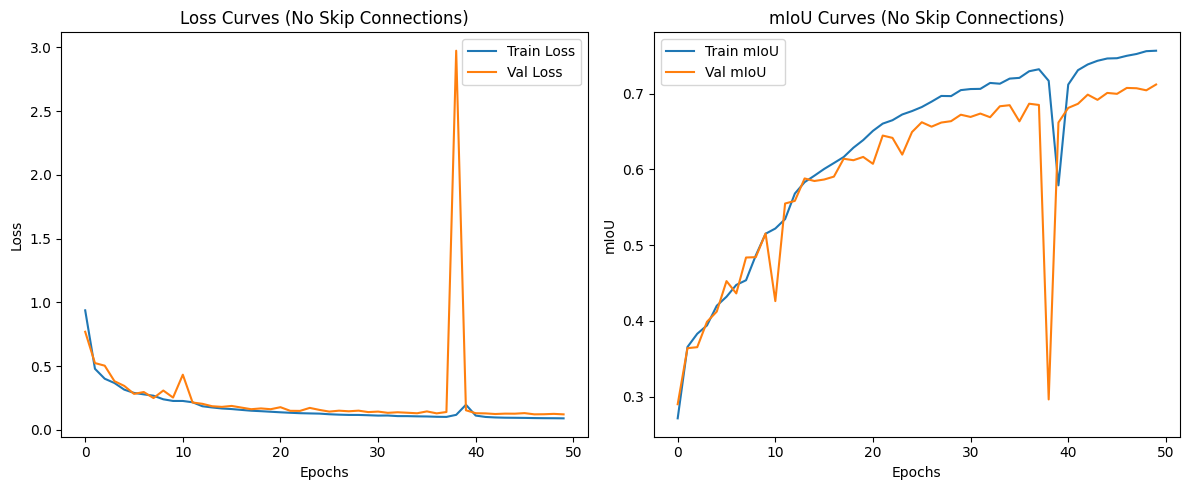

In [2]:

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Try to import albumentations if available, otherwise use basic transformations
try:
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    
    train_transform = A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    val_transform = A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    # Create datasets with transforms
    train_dataset = SegmentationDataset(train_images_path, train_labels_path, transform=train_transform)
    
    # Split training data into train and validation sets
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
    
    test_dataset = SegmentationDataset(test_images_path, test_labels_path, transform=val_transform)
    
    print(f"Using albumentations library for transformations")
    
except ImportError:
    print("Albumentations not available, using basic transformations")
    
    # Basic dataset class without albumentations
    class BasicSegmentationDataset(Dataset):
        def __init__(self, images_dir, masks_dir):
            self.images_dir = images_dir
            self.masks_dir = masks_dir
            self.images = sorted(os.listdir(images_dir))
            
        def __len__(self):
            return len(self.images)
        
        def __getitem__(self, idx):
            img_name = self.images[idx]
            img_path = os.path.join(self.images_dir, img_name)
            mask_path = os.path.join(self.masks_dir, img_name)
            
            # Load image and mask
            image = np.array(Image.open(img_path).convert("RGB"))
            mask = np.array(Image.open(mask_path))
            
            # Extract class IDs from mask
            if len(mask.shape) > 2:
                mask = mask[:, :, 0]  # Take first channel if multiple channels
            
            # Basic transformation
            image = image.transpose(2, 0, 1).astype(np.float32) / 255.0
            image = torch.from_numpy(image)
            mask = torch.from_numpy(mask).long()  # Explicitly convert to Long type
            
            return image, mask
    
    # Create datasets without special transforms
    train_dataset = BasicSegmentationDataset(train_images_path, train_labels_path)
    
    # Split training data into train and validation sets
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
    
    test_dataset = BasicSegmentationDataset(test_images_path, test_labels_path)



# Print dataset sizes
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Create data loaders with proper batch size for Kaggle GPUs
batch_size = 8  # Lower batch size to avoid CUDA out of memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Initialize the U-Net model without skip connections
model_noskip = UNetNoSkip(n_channels=3, n_classes=num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_noskip.parameters(), lr=0.001)

# Print model summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {count_parameters(model_noskip)}")

# Train the model
print("Starting model training for U-Net without skip connections...")
train_losses, val_losses, train_mious, val_mious = train_model(
    model=model_noskip,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=50,  
    device=device
)



<ipython-input-3-39a65e2174bd>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_noskip.load_state_dict(torch.load('best_unet_noskip_model.pth'))


Loading best model for testing...
Testing model on test dataset...


Testing: 100%|██████████| 63/63 [00:09<00:00,  6.76it/s]


Test mIoU: 0.6930
Final Test mIoU for U-Net without Skip Connections: 0.6930

Sample Predictions from Test Set (U-Net without Skip Connections):


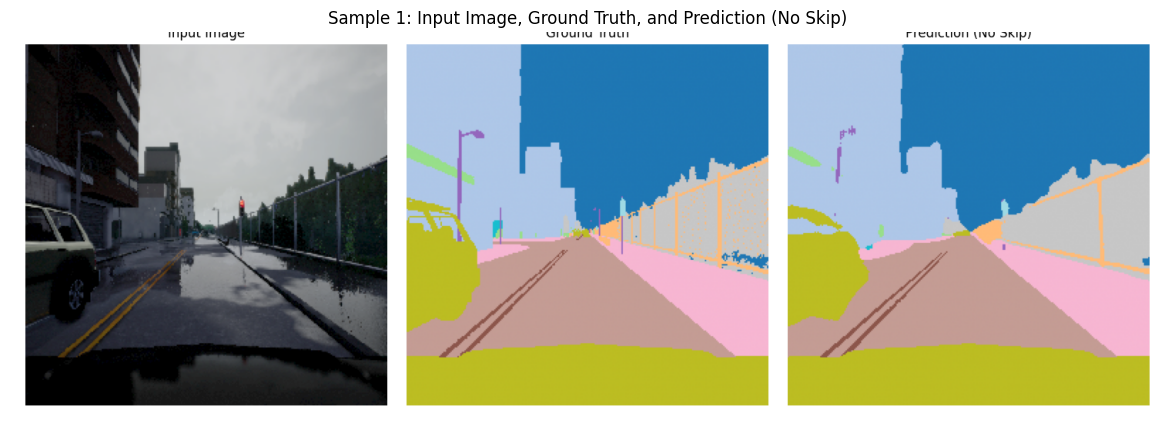

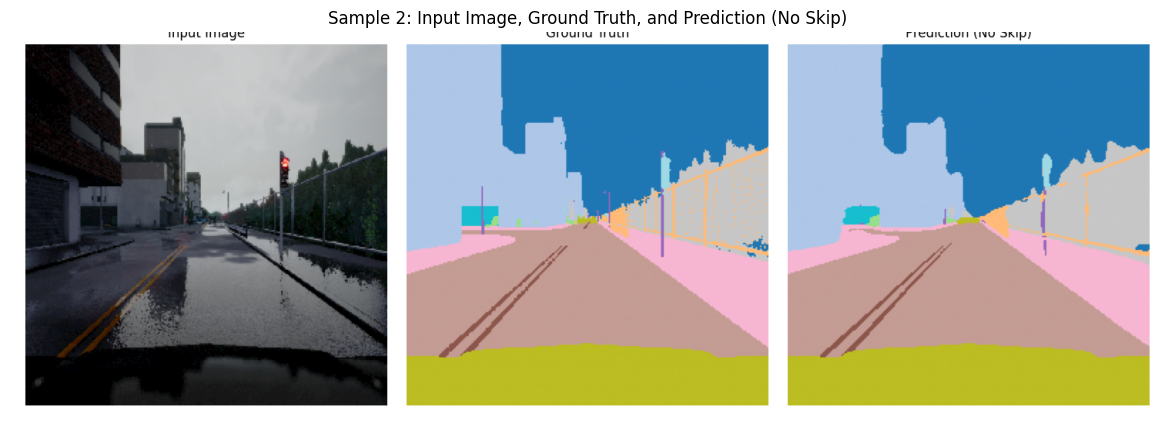

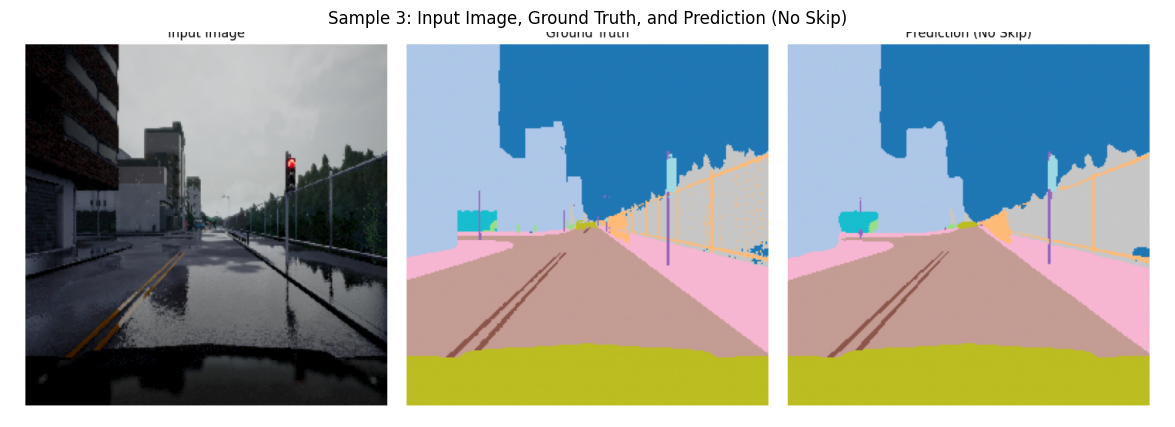

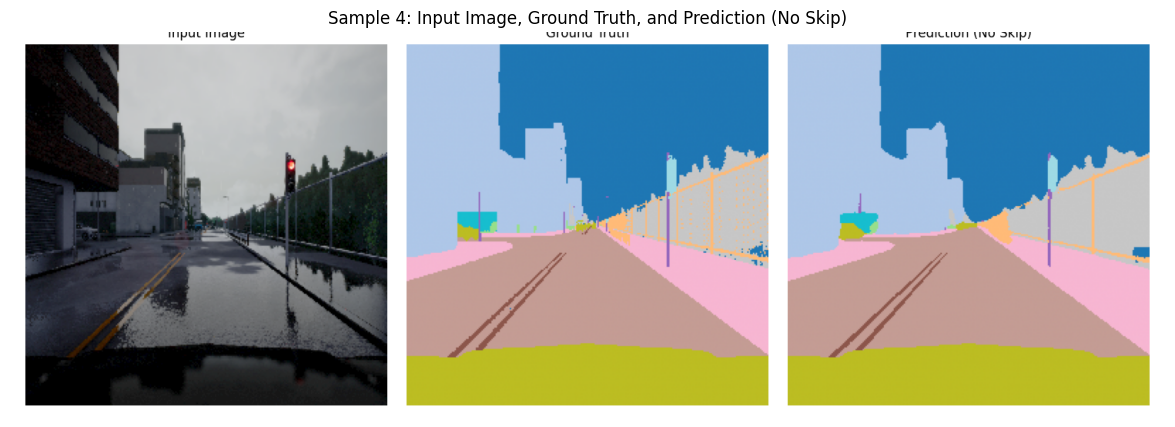

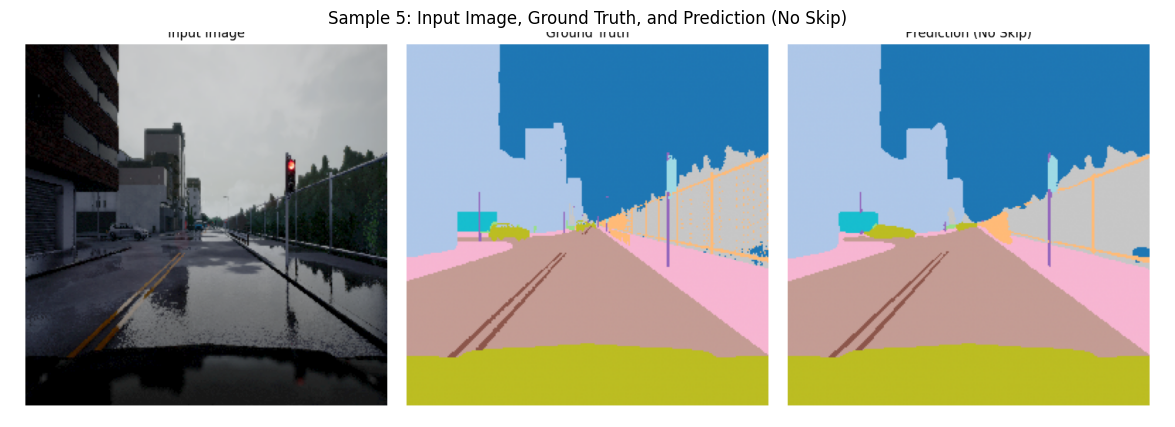

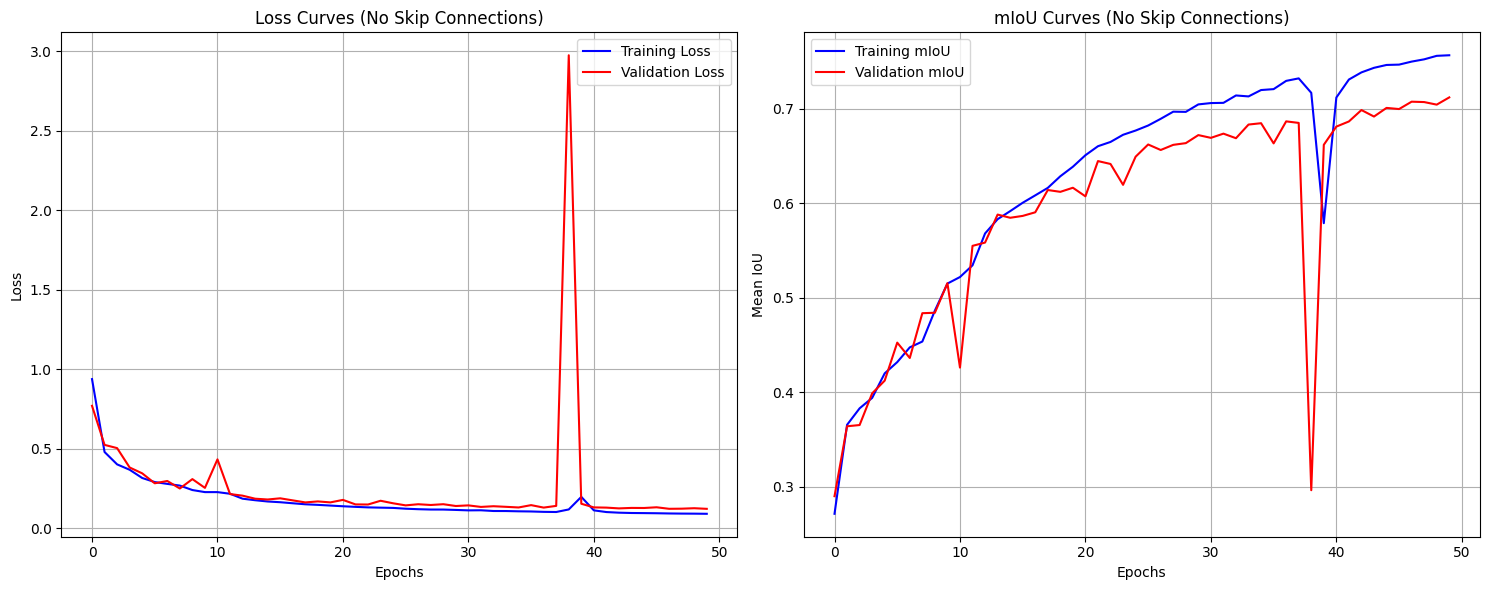

Best Training mIoU: 0.7566
Best Validation mIoU: 0.7120
Final Test mIoU: 0.6930


In [3]:

# Load best model for testing
print("Loading best model for testing...")
model_noskip.load_state_dict(torch.load('best_unet_noskip_model.pth'))

# Test the model
print("Testing model on test dataset...")
test_miou = test_model(model_noskip, test_loader, device)
print(f"Final Test mIoU for U-Net without Skip Connections: {test_miou:.4f}")

# Display sample predictions
print("\nSample Predictions from Test Set (U-Net without Skip Connections):")
for i in range(5):
    vis_path = f'no_skip_prediction_{i}.png'
    if os.path.exists(vis_path):
        img = plt.imread(vis_path)
        plt.figure(figsize=(15, 5))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Sample {i+1}: Input Image, Ground Truth, and Prediction (No Skip)')
        plt.show()
    else:
        print(f"Warning: Visualization file {i} not found")

# Show training curves in more detail
plt.figure(figsize=(15, 6))

# Plot loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Training Loss')
plt.plot(val_losses, 'r-', label='Validation Loss')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves (No Skip Connections)')
plt.legend()

# Plot mIoU curves
plt.subplot(1, 2, 2)
plt.plot(train_mious, 'b-', label='Training mIoU')
plt.plot(val_mious, 'r-', label='Validation mIoU')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.title('mIoU Curves (No Skip Connections)')
plt.legend()

plt.tight_layout()
plt.savefig('detailed_training_curves_noskip.png')
plt.show()

# Print the best mIoU values
best_train_miou = max(train_mious)
best_val_miou = max(val_mious)
print(f"Best Training mIoU: {best_train_miou:.4f}")
print(f"Best Validation mIoU: {best_val_miou:.4f}")
print(f"Final Test mIoU: {test_miou:.4f}")

